<a href="https://colab.research.google.com/github/niharikanagaraj/niharika/blob/main/Fake%20News%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import urllib.request # to import images from dataset
import sys

from sklearn.model_selection import train_test_split

In [ ]:
# Import Neural Network and PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim

import torchvision
from torchvision.transforms import v2
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim.lr_scheduler as lr_scheduler

import random
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
df = pd.read_csv('multimodal_train.tsv', sep='\t')

In [ ]:
df.drop(['2_way_label', '3_way_label', 'title'], axis=1, inplace=True)

In [ ]:
df.head()

author                                        clean_title  \
0     Alexithymia  my walgreens offbrand mucinex was engraved wit...   
1        VIDCAs17                this concerned sink with a tiny hat   
2  prometheus1123      hackers leak emails from uae ambassador to us   
3             NaN                           puppy taking in the view   
4       3rikR3ith               i found a face in my sheet music too   

    created_utc         domain  hasImage      id  \
0  1.551641e+09    i.imgur.com      True  awxhir   
1  1.534727e+09      i.redd.it      True  98pbid   
2  1.496511e+09  aljazeera.com      True  6f2cy5   
3  1.471341e+09    i.imgur.com      True  4xypkv   
4  1.525318e+09      i.redd.it      True  8gnet9   

                                           image_url linked_submission_id  \
0  https://external-preview.redd.it/WylDbZrnbvZdB...                  NaN   
1  https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...                  NaN   
2  https://external-preview.redd.it/6fNhdbc6K1vFA...                  NaN   
3  https://external-preview.redd.it/HLtVNhTR6wtYt...                  NaN   
4  https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...                  NaN   

   num_comments  score          subreddit  upvote_ratio  6_way_label  
0           2.0     12  mildlyinteresting          0.84            0  
1           2.0    119         pareidolia          0.99            2  
2           1.0     44        neutralnews          0.92            0  
3          26.0    250   photoshopbattles          0.95            0  
4           2.0     13         pareidolia          0.84            2

In [ ]:
df.shape

(564000, 13)

In [ ]:
df, _ = train_test_split(
    df,
    test_size=0.97,
    shuffle=True,
    stratify=df["6_way_label"]
)

In [ ]:
df.shape

(16920, 13)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
# Check for Nan values
print("clean_title:", df["clean_title"].isnull().sum())
print("has_image:", df["hasImage"].isnull().sum())
print("id:", df["id"].isnull().sum())

# Check how many rows with the column "hasImage" is false
print("\n", df["hasImage"].value_counts())

clean_title: 0
has_image: 0
id: 0

 hasImage
True    16920
Name: count, dtype: int64


<Axes: title={'center': '6_way_label'}, ylabel='Frequency'>

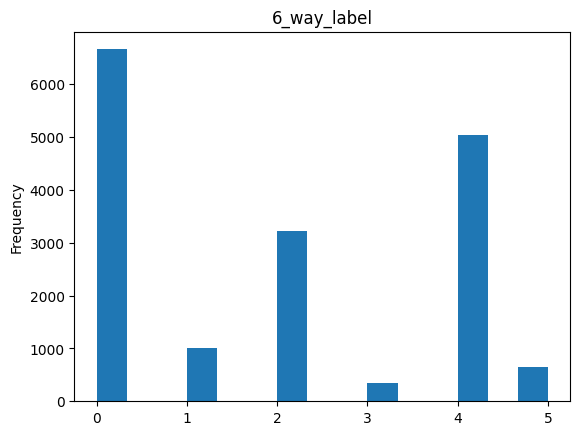

In [ ]:
df["6_way_label"].plot(kind="hist", bins=15, title="6_way_label")

In [ ]:
import os
import numpy as np
from urllib import request
from concurrent.futures import ThreadPoolExecutor, as_completed

# Replace NaN values with empty strings
df = df.replace(np.nan, '', regex=True)
df.fillna('', inplace=True)

# Create the directory to store images if it doesn't exist
image_dir = "/kaggle/working/images"
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

# Function to download a single image
def download_image(row):
    image_url = row["image_url"]
    image_path = os.path.join(image_dir, f"{row['id']}.jpg")

    try:
        # Download the image and save it to the file path
        with open(image_path, 'wb') as f:
            f.write(request.urlopen(image_url).read())
        return True  # Success
    except Exception as e:
        return False  # Failed to download

# Function to process a single row in the dataframe
def process_row(index, row):
    if row["hasImage"] and row["image_url"] not in ["", "nan"]:
        success = download_image(row)
        if not success:
            # Remove the row from the dataframe if download fails
            return index
    return None

# Use ThreadPoolExecutor to download images concurrently
failed_indices = []
with ThreadPoolExecutor(max_workers=10) as executor:  # You can adjust the number of threads with max_workers
    futures = {executor.submit(process_row, index, row): index for index, row in df.iterrows()}

    for future in as_completed(futures):
        index = futures[future]
        try:
            failed_index = future.result()
            if failed_index is not None:
                failed_indices.append(failed_index)
        except Exception as exc:
            print(f"An error occurred for row {index}: {exc}")

# Remove failed rows from the dataframe
df.drop(index=failed_indices, inplace=True)
df.reset_index(drop=True, inplace=True)

print("Downloaded all images.")


Downloaded all images.


In [ ]:
def validate_images(directory):
    corrupted_files = []

    # Walk through directory and sub-directories
    for index, row in df.iterrows():
      image_path = "/kaggle/working/images/" + row["id"] + ".jpg"
      try:
          with Image.open(image_path) as img:
              img.verify()
      except Exception as e:
          corrupted_files.append(image_path)
          # print(f"Error with {image_path}: {e}")
          df.drop(index=index, axis=0, inplace=True)

    return corrupted_files


# Example usage:
directory = "/kaggle/working/images/"
corrupted_images = validate_images(directory)
if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images.")
else:
    print("All images are valid!")
df.reset_index(drop=True, inplace=True)

Found 54 corrupted images.


In [ ]:
# Resize all images to (256, 256, 3)
new_size = (256, 256)

for index, row in df.iterrows():
    image_path = "/kaggle/working/images/" + row["id"] + ".jpg"
    image = Image.open(image_path).convert("RGB")

    resize_transform = v2.Resize(new_size)
    resized_image = resize_transform(image)
    resized_image.save(image_path)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
!pip install --quiet transformers

In [ ]:
from transformers import BertModel, BertTokenizer


model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name, output_hidden_states=True)

# Put the model in evaluation mode, which turns off dropout regularization which is used in training.
bert_model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_bert_embedding(text):
    inputs = tokenizer.encode_plus(
        text, add_special_tokens=True,
        return_tensors="pt",
        max_length=80,
        truncation=True,
        padding="max_length"
    )

    return inputs["input_ids"].squeeze(0), inputs["attention_mask"].squeeze(0)


# Test embedding
text = "this is an embedding example for fake news detection"
input_ids, attention_mask = get_bert_embedding(text=text)
print(input_ids.shape)
print(attention_mask.shape)
print(input_ids)
print(attention_mask)

torch.Size([80])
torch.Size([80])
tensor([  101,  2023,  2003,  2019,  7861,  8270,  4667,  2742,  2005,  8275,
         2739, 10788,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["6_way_label"]
)

df_test, df_val = train_test_split(
    df_test,
    test_size=0.5,
    stratify=df_test["6_way_label"]
)

In [ ]:
class FakedditDataset(Dataset):
    def __init__(self, df, text_field="clean_title", label_field="6_way_label",
                 image_id="id", is_training=True):
        self.df = df.reset_index(drop=True)
        self.text_field = text_field
        self.label_field = label_field
        self.image_id = image_id
        self.is_training = is_training

        # Training augmentations
        if is_training:
            self.transform_func = v2.Compose([
                v2.Resize((286, 286)),  # Larger size for random crop
                v2.RandomCrop((256, 256)),
                v2.RandomHorizontalFlip(),
                v2.ColorJitter(brightness=0.2, contrast=0.2),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            # Validation/test transforms
            self.transform_func = v2.Compose([
                v2.Resize((256, 256)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])


    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.df.at[index, self.label_field]

        image_path = "/kaggle/working/images/" + self.df.at[index, self.image_id] + ".jpg"
        image = Image.open(image_path)
        image = self.transform_func(image)

        input_ids, attention_mask = get_bert_embedding(text)

        return image, input_ids, attention_mask, label, index


    def __len__(self):
        return self.df.shape[0]

In [ ]:
train_data = FakedditDataset(df_train)
val_data = FakedditDataset(df_val, is_training=False)
test_data = FakedditDataset(df_test, is_training=False)

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

# Verify if dataset is created accurately
image, input_ids, attention_mask, label, indices = next(iter(train_loader))
print(input_ids.shape, attention_mask.shape, label.shape, image.shape, indices.shape)

torch.Size([16, 80]) torch.Size([16, 80]) torch.Size([16]) torch.Size([16, 3, 256, 256]) torch.Size([16])


In [ ]:
class EarlyStopping:
    def __init__(self, patience=4, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=5, verbose=True)

  # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for img, input_ids, attention_mask, label, indices in train_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)

            optimizer.zero_grad()

          # Forward pass
            outputs = model(img, input_ids, attention_mask)
            loss = criterion(outputs, label)

          # Backward pass and optimization
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item() * img.size(0)

       # Validating model and ensuring loss is decreasing
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        with torch.no_grad():
            for img, input_ids, attention_mask, label, indices in val_loader:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                label = label.to(device)
                img = img.to(device)

                outputs = model(img, input_ids, attention_mask)
                loss = criterion(outputs, label)
                val_loss += loss.item() * img.size(0)

                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == label)

        val_loss = val_loss / len(val_loader.dataset)
        accuracy = correct_preds.double() / len(val_loader.dataset)
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader.dataset):.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

In [ ]:
from sklearn.metrics import precision_score, recall_score

def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_losses = []
    correct_preds = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img, input_ids, attention_mask, label, indices in test_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)

            outputs = model(
                  image = img,
                  text_input_ids = input_ids,
                  text_attention_mask = attention_mask
            )

            # Final Softmax layer returns class predictions per sample in batch
            # Highest probability value resembles class prediction and is assigned to preds variable
            _, preds = torch.max(outputs, dim=1)
            #print(outputs)

            # Loss is calculated by applying Cross Entropy Loss
            val_loss = criterion(outputs, label)

            # Counting correct model predictions and incrementing correct prediction count
            correct_preds += torch.sum(preds == label)
#             print(preds, label)

            # Appending current loss per batch to list of losses per epoch
            val_losses.append(val_loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())


    accuracy = float((correct_preds.double() / len(df_test)) * 100)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print("\nAccuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)

In [ ]:
class BERTResNetClassifier(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.3):
        super(BERTResNetClassifier, self).__init__()

        # Image processing
        self.image_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        # Freeze early layers
        for i, child in enumerate(self.image_model.children()):
            if i < 6:  # Freeze first 6 layers
                for param in child.parameters():
                    param.requires_grad = False

        # Modify image branch with more regularization
        self.fc_image = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate)
        )

        # Text processing
        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        # Freeze BERT layers except last few
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.encoder.layer[-2:].parameters():
            param.requires_grad = True

        # Modify text branch with more regularization
        self.fc_text = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate)
        )

        # Fusion and classification layers
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, text_input_ids, text_attention_mask):
        # Image branch
        x_img = self.image_model(image)
        x_img = self.fc_image(x_img)

        # Text branch with attention-weighted pooling
        text_outputs = self.text_model(
            input_ids=text_input_ids,
            attention_mask=text_attention_mask,
            return_dict=True
        )

        # Attention-weighted pooling
        attention_weights = text_attention_mask.unsqueeze(-1).float()
        x_text = torch.sum(text_outputs.last_hidden_state * attention_weights, dim=1)
        x_text = x_text / torch.sum(attention_weights, dim=1)
        x_text = self.fc_text(x_text)

        # Average fusion
#         x_fused = (x_text + x_img) / 2
        x_fused = torch.max(x_text, x_img)

        # Classification
        x_out = self.classifier(x_fused)
        return x_out

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

labels = df_train['6_way_label'].to_numpy()
# Assuming 'labels' is a list of all labels in the dataset
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = BERTResNetClassifier(num_classes=6)
model= model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-5, factor=0.5, patience=1, verbose=True)
num_epochs = 10

train_model(model, train_loader,val_loader, criterion, optimizer, scheduler, num_epochs)
#print("\n")
evaluate_model(model, test_loader, criterion)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


Epoch 1/10, Training Loss: 1.4552, Validation Loss: 1.1834, Accuracy: 0.5386
Epoch 2/10, Training Loss: 1.1805, Validation Loss: 1.6361, Accuracy: 0.5617
EarlyStopping counter: 1 out of 5
Epoch 3/10, Training Loss: 0.9993, Validation Loss: 1.0031, Accuracy: 0.6593
Epoch 4/10, Training Loss: 0.8164, Validation Loss: 1.1527, Accuracy: 0.7329
EarlyStopping counter: 1 out of 5
Epoch 5/10, Training Loss: 0.6688, Validation Loss: 1.8537, Accuracy: 0.6841
EarlyStopping counter: 2 out of 5
Epoch 6/10, Training Loss: 0.4665, Validation Loss: 2.4123, Accuracy: 0.7303
EarlyStopping counter: 3 out of 5
Epoch 7/10, Training Loss: 0.3463, Validation Loss: 1.2732, Accuracy: 0.7817
EarlyStopping counter: 4 out of 5
Epoch 8/10, Training Loss: 0.2492, Validation Loss: 1.5308, Accuracy: 0.7870
EarlyStopping counter: 5 out of 5
Early stopping triggered. Stopping training.

Accuracy:  77.26465364120781
Precision:  0.7705021383175797
Recall:  0.7726465364120781


In [ ]:
# Assuming you already have a test/validation DataLoader
model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for img, input_ids, attention_mask, label, indices in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        label = label.to(device)
        img = img.to(device)

        outputs = model(
              image = img,
              text_input_ids = input_ids,
              text_attention_mask = attention_mask
        )

        # Final Softmax layer returns class predictions per sample in batch
        # Highest probability value resembles class prediction and is assigned to preds variable
        _, preds = torch.max(outputs, dim=1)
        #print(outputs)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

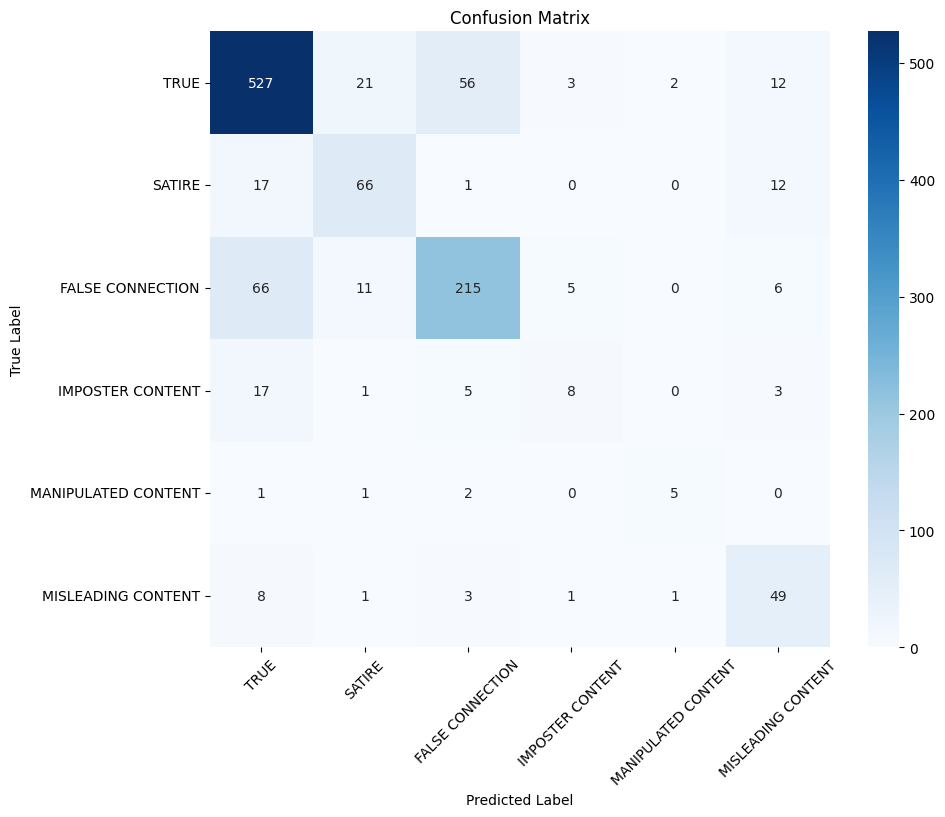

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = [
    'TRUE',
    'SATIRE',
    'FALSE CONNECTION',
    'IMPOSTER CONTENT',
    'MANIPULATED CONTENT',
    'MISLEADING CONTENT'
]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np

# Calculate false predictions for each class
total_per_class = np.sum(cm, axis=1)
correct_per_class = np.diagonal(cm)
false_per_class = total_per_class - correct_per_class

# Calculate percentage of false predictions per class
false_percentage_per_class = (false_per_class / total_per_class) * 100

# Display the results
for idx, class_name in enumerate(class_names):
    print(f"Class '{class_name}' - False Predictions: {false_percentage_per_class[idx]:.2f}%")



Class 'TRUE' - False Predictions: 15.14%
Class 'SATIRE' - False Predictions: 31.25%
Class 'FALSE CONNECTION' - False Predictions: 29.04%
Class 'IMPOSTER CONTENT' - False Predictions: 76.47%
Class 'MANIPULATED CONTENT' - False Predictions: 44.44%
Class 'MISLEADING CONTENT' - False Predictions: 22.22%


In [ ]:
total_per_class


array([621,  96, 303,  34,   9,  63])

In [ ]:
# Find class with most false predictions
max_false_class_idx = np.argmax(false_percentage_per_class)
print(f"Class with most false predictions: {class_names[max_false_class_idx]} ({false_percentage_per_class[max_false_class_idx]:.2f}%)")

Class with most false predictions: IMPOSTER CONTENT (76.47%)


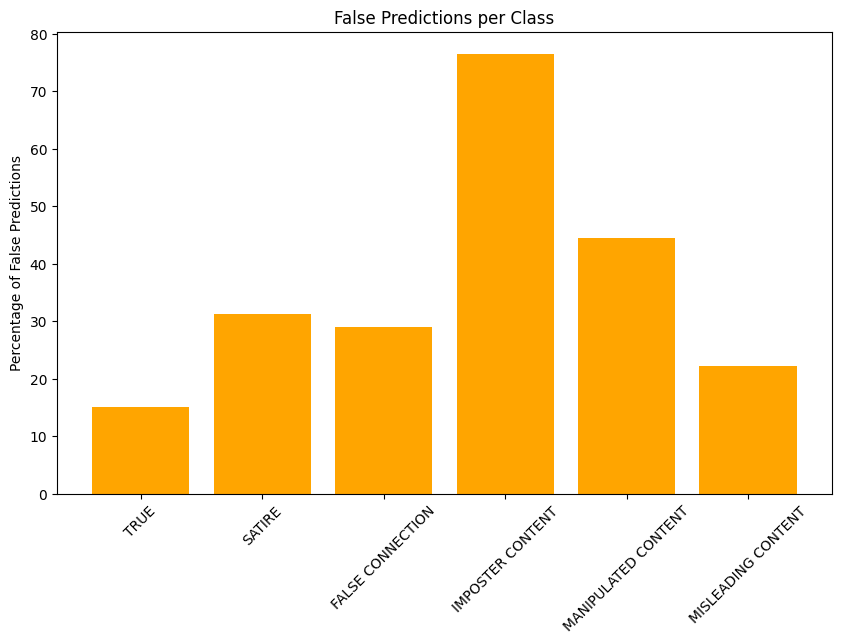

In [ ]:
# Plot false prediction percentages as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, false_percentage_per_class, width=0.8, color='orange')
plt.ylabel('Percentage of False Predictions')
plt.xticks(rotation=45)
plt.title('False Predictions per Class')
plt.show()

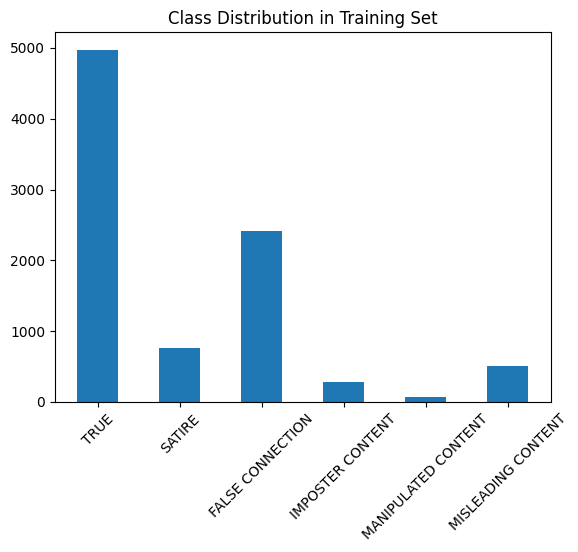

In [ ]:
plt.hist(df_train["6_way_label"], bins=np.arange(len(class_names)+1) -0.5, rwidth=0.5)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title('Class Distribution in Training Set')
plt.show()

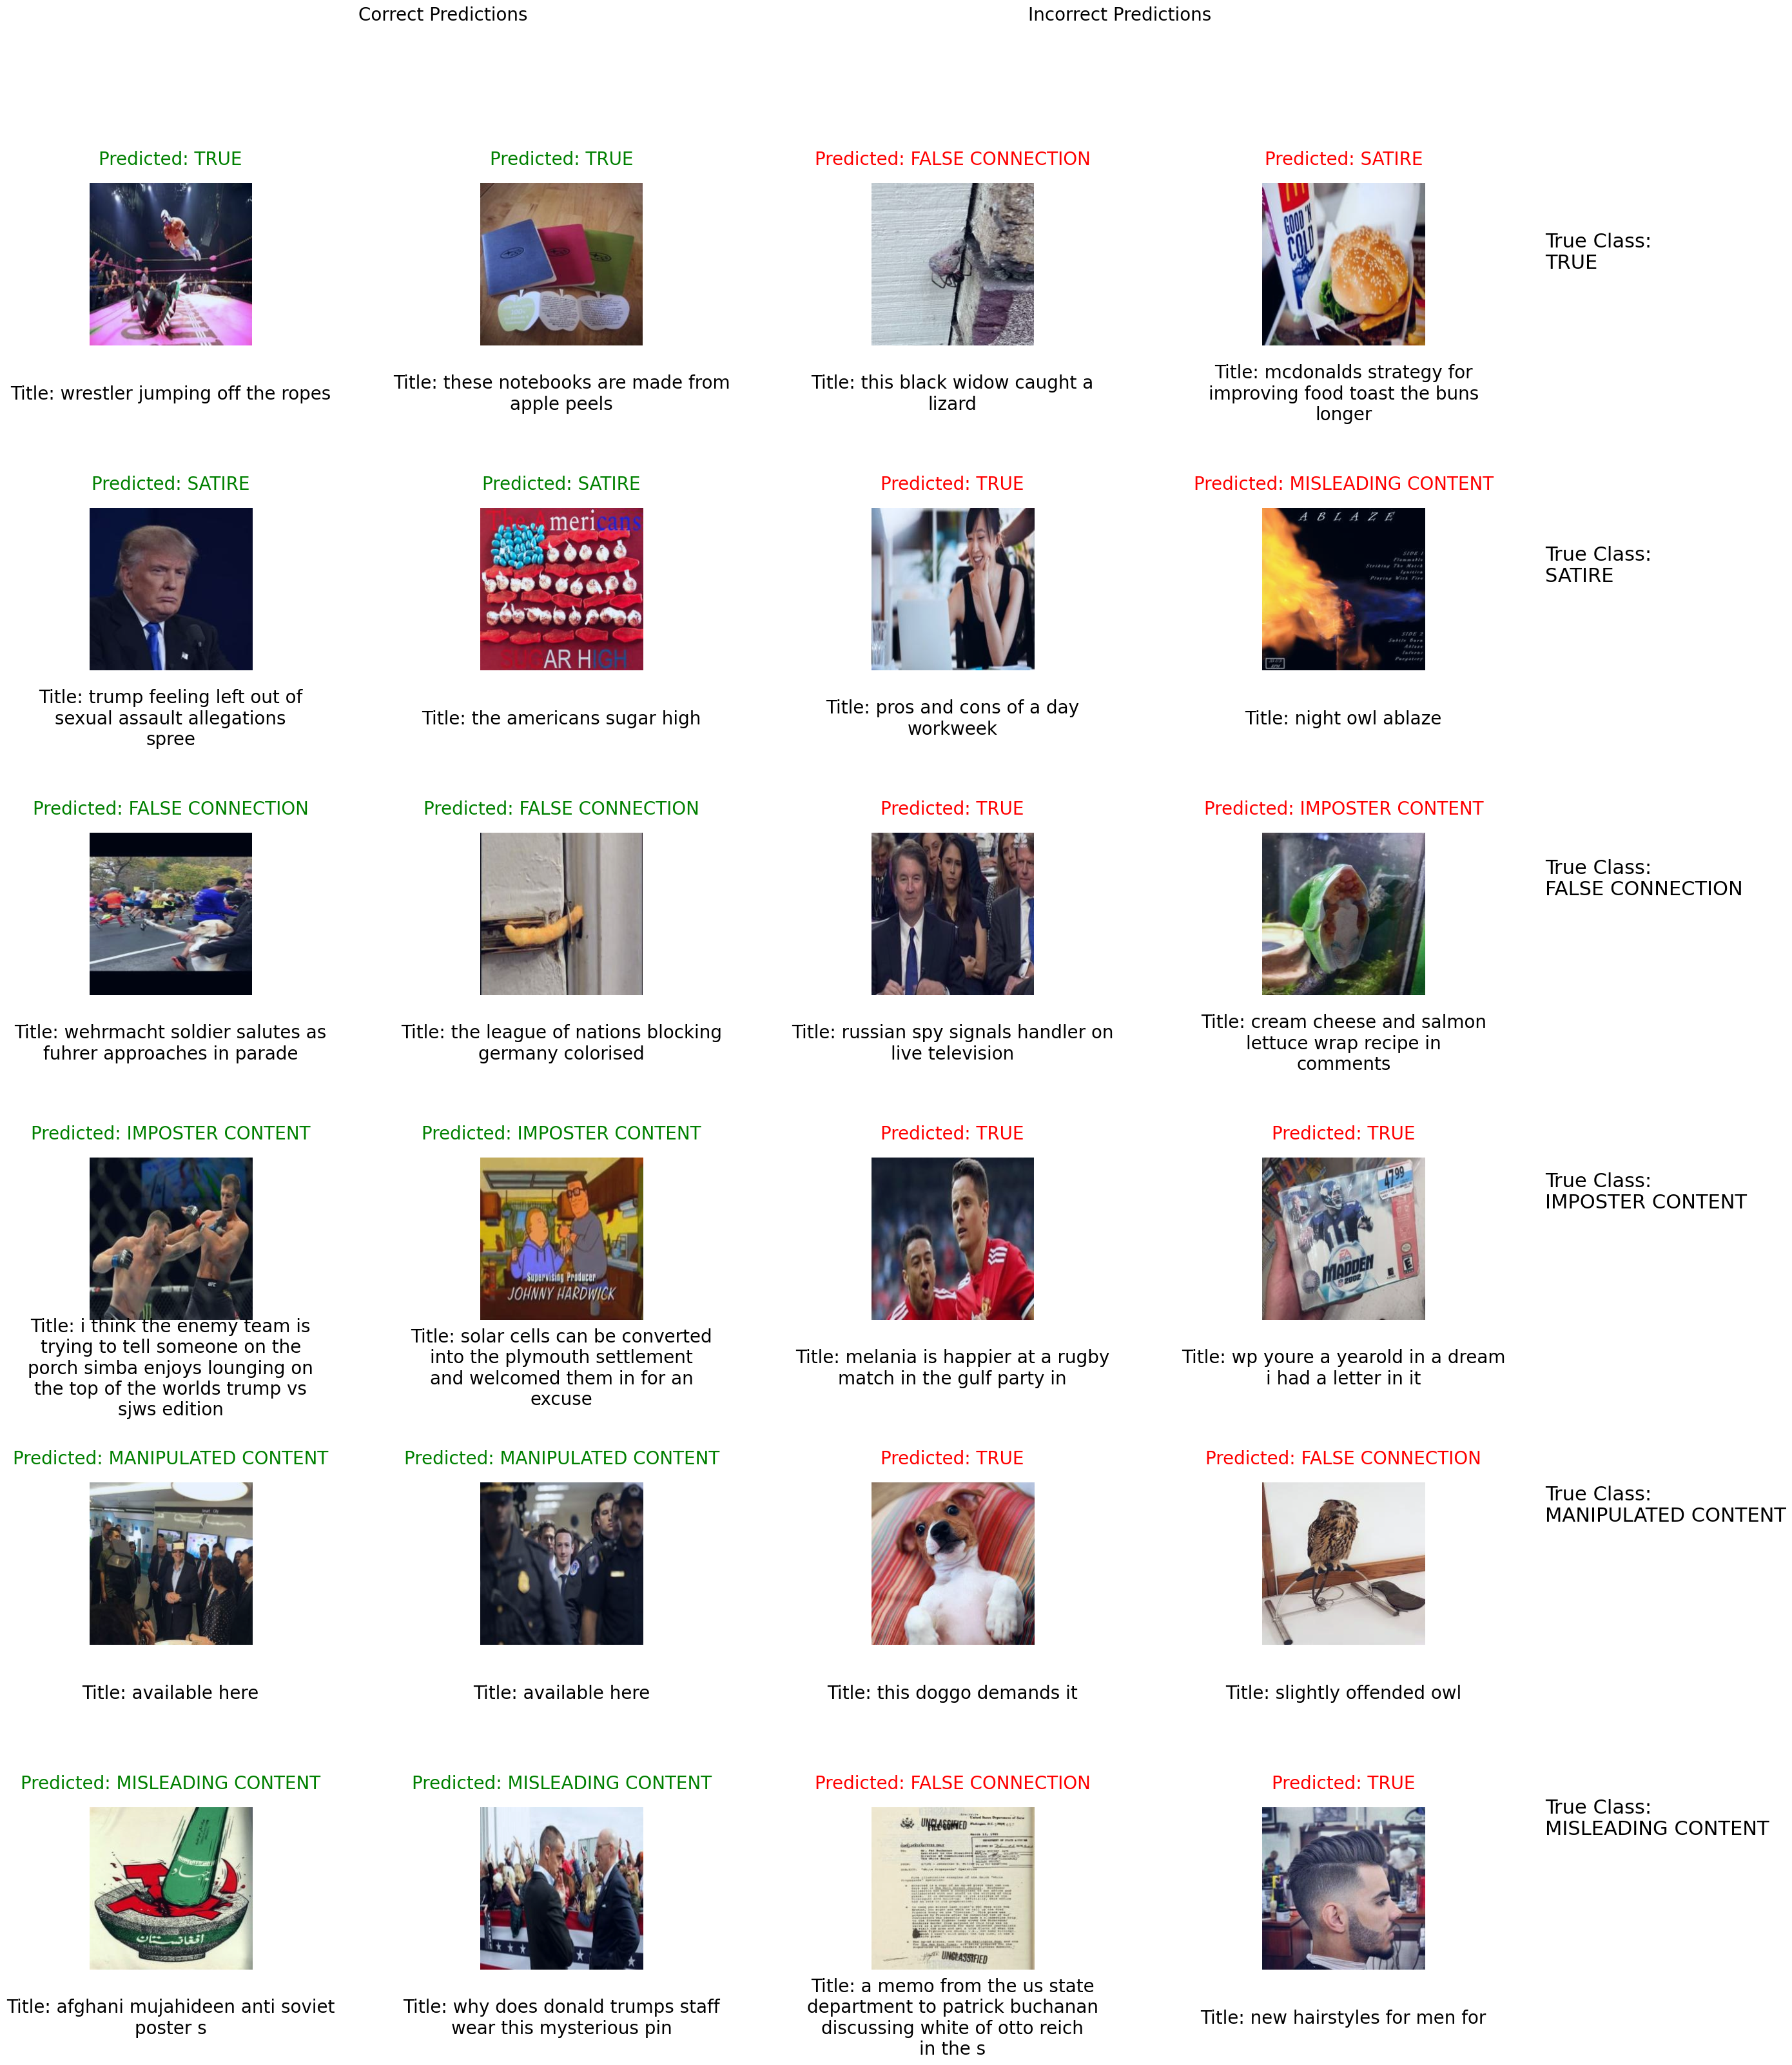

In [ ]:
import textwrap

def display_predictions(test_loader, model, device):
    """
    Displays 4 images per class with true labels, predicted labels, and clean titles
    """
    model.eval()

    # Initialize figure (6 classes × 4 samples per class)
    fig, axs = plt.subplots(6, 4, figsize=(30, 36))
    plt.subplots_adjust(hspace=1.0)  # Increased spacing for title text

    class_names = [
        'TRUE',
        'SATIRE',
        'FALSE CONNECTION',
        'IMPOSTER CONTENT',
        'MANIPULATED CONTENT',
        'MISLEADING CONTENT'
    ]

    # Dictionary to store samples for each class
    class_samples = {i: {'correct': [], 'incorrect': []} for i in range(6)}

    class_titles = []

    # Collect samples
    with torch.no_grad():
        for images, input_ids, attention_mask, labels, indices in test_loader:

            clean_titles = test_loader.dataset.df.iloc[indices]['clean_title'].tolist()

            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(images, input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            # Store samples with their titles
            for img, true_label, pred_label, title in zip(images, labels, predictions, clean_titles):
                true_label = true_label.item()
                pred_label = pred_label.cpu().item()

                is_correct = true_label == pred_label
                category = 'correct' if is_correct else 'incorrect'

                if len(class_samples[true_label][category]) < 2:
                    class_samples[true_label][category].append((
                        img.cpu(),
                        true_label,
                        pred_label,
                        title
                    ))

            if all(len(samples['correct']) == 2 and len(samples['incorrect']) == 2
                   for samples in class_samples.values()):
                break

    # Display images
    for class_idx in range(6):
        # Add true label on the right
        fig.text(0.92, 0.85 - (class_idx * 0.135),
                f"True Class:\n{class_names[class_idx]}",
                fontsize=22,
                verticalalignment='center')

        # Display correct predictions
        for i, (img, true_label, pred_label, title) in enumerate(class_samples[class_idx]['correct']):
            ax = axs[class_idx, i]

            img_np = np.transpose(img.numpy(), (1, 2, 0))
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

            ax.imshow(img_np)

            # Add predicted label on top
            ax.set_title(f'Predicted: {class_names[pred_label]}',
                        {'color': 'green', 'fontsize': 20},
                        pad=20)

            # Wrap clean_title if it is too long
            wrapped_title = "\n".join(textwrap.wrap(title, width=30))  # Adjust width as needed

            # Add clean_title at the bottom
            ax.text(0.5, -0.3, f"Title: {wrapped_title}",
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax.transAxes,
                   fontsize=20,
                   wrap=True)

            ax.axis('off')

        # Display incorrect predictions
        for i, (img, true_label, pred_label, title) in enumerate(class_samples[class_idx]['incorrect']):
            ax = axs[class_idx, i+2]

            img_np = np.transpose(img.numpy(), (1, 2, 0))
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

            ax.imshow(img_np)

            # Add predicted label on top
            ax.set_title(f'Predicted: {class_names[pred_label]}',
                        {'color': 'red', 'fontsize': 20},
                        pad=20)

            # Wrap clean_title if it is too long
            wrapped_title = "\n".join(textwrap.wrap(title, width=30))  # Adjust width as needed

            # Add clean_title at the bottom
            ax.text(0.5, -0.3, f"Title: {wrapped_title}",
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax.transAxes,
                   fontsize=20,
                   wrap=True)

            ax.axis('off')

    # Add column labels
    fig.text(0.35, 0.95, 'Correct Predictions', fontsize=20, ha='center')
    fig.text(0.7, 0.95, 'Incorrect Predictions', fontsize=20, ha='center')

    plt.show()


# Usage
model.to(device)
display_predictions(test_loader, model, device)